# **Anomaly Detection - SetNo1**

**Set No. 1**

| Index                    | Description                                                                                                                   |
|--------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| Recording Duration:      | October 22, 2003 12:06:24 to November 25, 2003 23:39:56                                                                       |
| No. of Files:            | 2,156                                                                                                                         |
| No. of Channels:         | 8                                                                                                                             |
| Channel Arrangement:     | Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4; Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8.                                               |
| File Recording Interval: | Every 10 minutes (except the first 43 files were taken every 5 minutes)                                                       |
| File Format:             | ASCII                                                                                                                         |
| Description:             | At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4. |


Import Required Modules

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(color_codes=True)
%matplotlib inline

2025-02-20 11:11:08.696112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 11:11:09.542520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-20 11:11:09.542655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-20 11:11:09.542666: W tensorflow/compiler/tf2tensorrt/util

Load Data File for Test 2, Merged

In [2]:
merged_data = pd.read_csv('ProcessedData/MergedData/DatasetBearingTest_1.csv')
merged_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
merged_data.time = pd.to_datetime(merged_data['time'], format='%Y-%m-%d %H:%M:%S')
merged_data.index=merged_data['time']
merged_data = merged_data.sort_index()
merged_data.drop(columns=['time'], inplace=True)
merged_data

,Bearing 1x,Bearing 1y,Bearing 2x,Bearing 2y,Bearing 3x,Bearing 3y,Bearing 4x,Bearing 4y
time,,,,,,,,
2003-10-22 12:06:24,0.104148,0.100253,0.107147,0.102004,0.106149,0.108150,0.094803,0.099513
2003-10-22 12:09:13,0.103651,0.099854,0.108189,0.102920,0.106661,0.108458,0.095070,0.093587
2003-10-22 12:14:13,0.105039,0.101543,0.108543,0.104042,0.108740,0.109875,0.096158,0.098299
2003-10-22 12:19:13,0.104900,0.101573,0.108152,0.103378,0.108068,0.110010,0.096814,0.098602
2003-10-22 12:24:13,0.104779,0.102181,0.107943,0.102629,0.108454,0.109350,0.096358,0.098471
...,...,...,...,...,...,...,...,...
2003-11-25 16:07:32,0.138784,0.130001,0.151358,0.138561,0.209843,0.217346,0.165271,0.154710
2003-11-25 23:13:21,0.142147,0.131042,0.162772,0.149214,0.339327,0.330122,0.175640,0.163224
2003-11-25 23:19:56,0.142098,0.131348,0.167258,0.154300,0.357823,0.351640,0.184356,0.165720


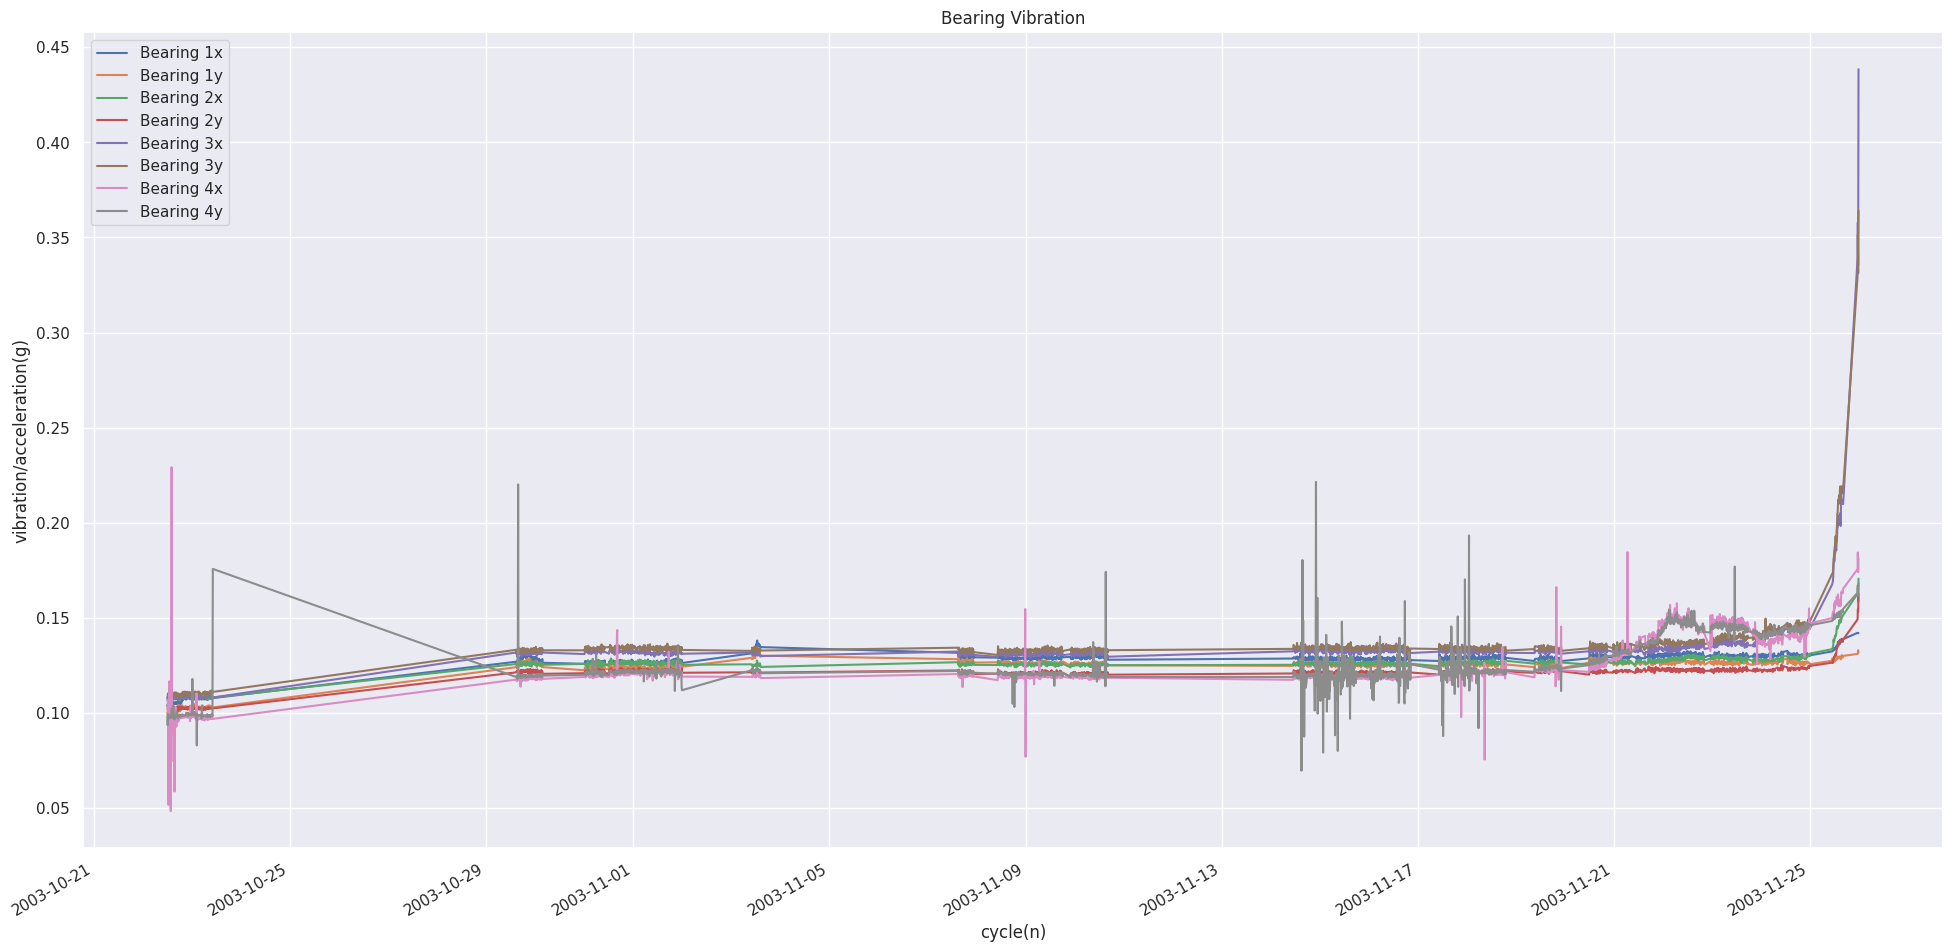

In [4]:
ax = merged_data.plot(figsize = (24,12), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

Split Data into Train and Test

In [5]:
split_index = int(0.7 * len(merged_data))

In [6]:
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

Normalize Data

In [22]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
X_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

We will use AutoEncoders to Get the Anomalies based on Reconstruction Error

In [52]:
X_train.shape

(1509, 8)

In [53]:
tf.random.set_seed(42)
autoencoder = Sequential([
    Dense(4, activation='elu', kernel_regularizer=regularizers.l2(0.0), input_shape=(X_train.shape[1],)),
    Dense(2, activation='elu'),
    Dense(4, activation='elu'),
    Dense(X_train.shape[1])
])

autoencoder.compile(optimizer='adam', loss='mse')

In [54]:
from keras.callbacks import EarlyStopping

# 設定 EarlyStopping 回調函式，當驗證損失在 10 個 epoch 內無改善時停止訓練
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# 加入 EarlyStopping 到 fit 的 callbacks 參數
history = autoencoder.fit(
    X_train, X_train,
    epochs=1000,
    batch_size=10,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
121/121 [==============================] - 2s 3ms/step - loss: 0.3276 - val_loss: 0.2491
Epoch 2/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.1281 - val_loss: 0.0716
Epoch 3/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0186
Epoch 4/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0051
Epoch 5/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 6/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 7/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 8/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 9/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 10/1000
121/121 [==============================] - 0s 2ms/step - loss: 0.001

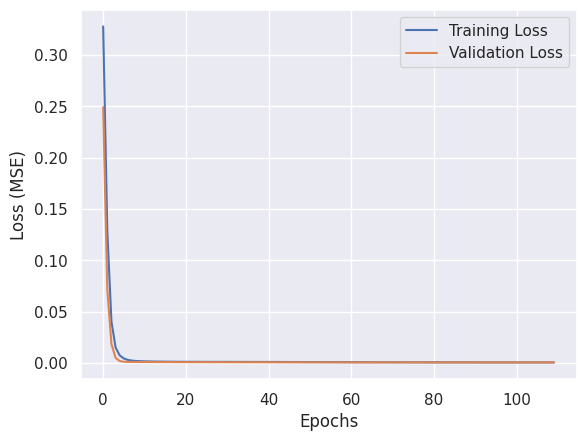

In [55]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()

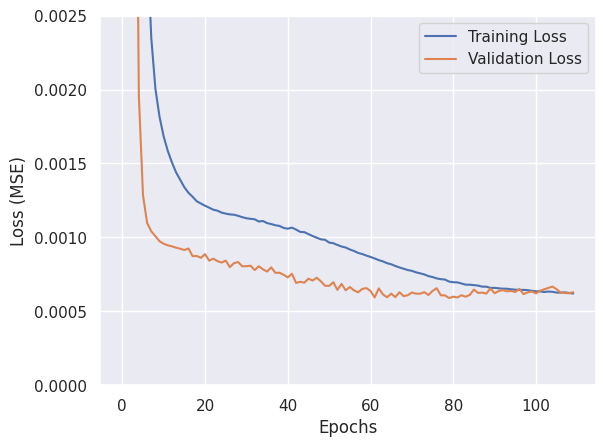

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.ylim(0, 0.0025)  # 限制 y 軸範圍
plt.show()

48/48 [==============================] - 0s 986us/step


<Figure size 640x480 with 0 Axes>

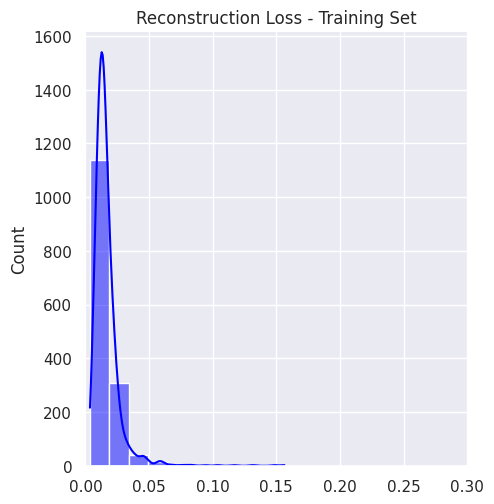

In [57]:
X_train_pred = autoencoder.predict(X_train)
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure()
sns.displot(train_loss, bins=10, kde=True, color='blue')
plt.title("Reconstruction Loss - Training Set")
plt.xlim([0.0, 0.3])
plt.show()

21/21 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

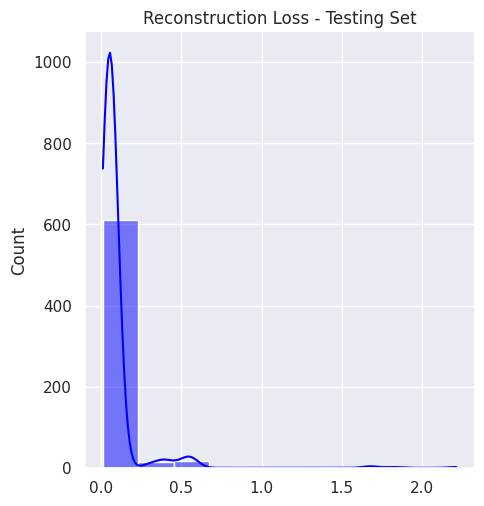

In [58]:
X_test_pred = autoencoder.predict(X_test)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
plt.figure()
sns.displot(test_loss, bins=10, kde=True, color='blue')
plt.title("Reconstruction Loss - Testing Set")
plt.show()

21/21 [==============================] - 0s 1ms/step


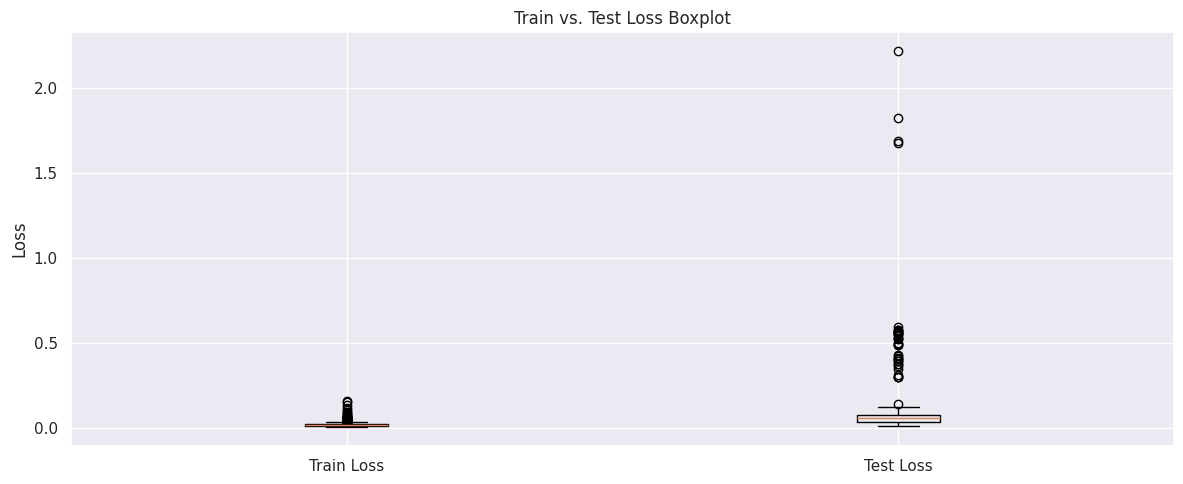

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# 取得 autoencoder 預測結果
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# 計算損失
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 繪製直方圖
plt.figure(figsize=(12, 5))

# 繪製箱型圖
plt.boxplot([train_loss, test_loss], labels=["Train Loss", "Test Loss"])
plt.ylabel("Loss")
plt.title("Train vs. Test Loss Boxplot")

plt.tight_layout()
plt.show()

21/21 [==============================] - 0s 1ms/step


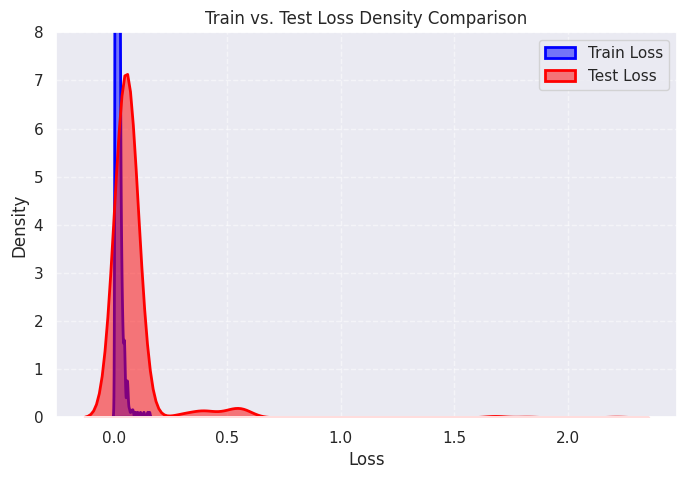

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 取得 autoencoder 預測結果
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# 計算損失
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 繪製 Kernel Density Estimation (KDE) 圖
plt.figure(figsize=(8, 5))
sns.kdeplot(train_loss, label="Train Loss", color="blue", fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(test_loss, label="Test Loss", color="red", fill=True, alpha=0.5, linewidth=2)

plt.xlabel("Loss")
plt.ylabel("Density")
plt.title("Train vs. Test Loss Density Comparison")
plt.ylim(top=8)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

21/21 [==============================] - 0s 1ms/step


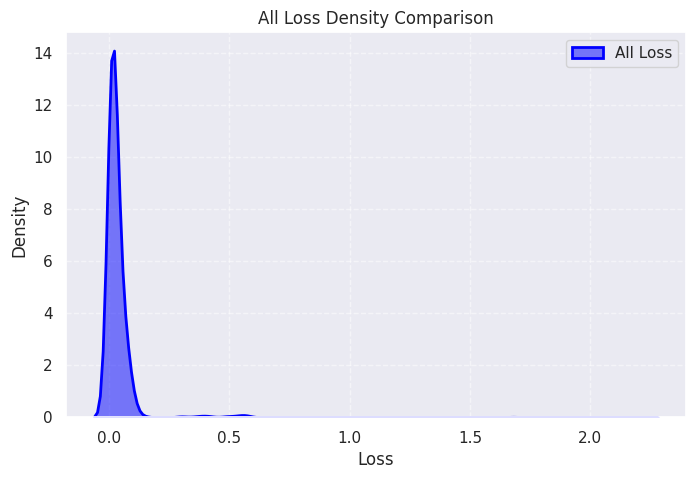

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 取得 autoencoder 預測結果
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# 計算損失
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 繪製 Kernel Density Estimation (KDE) 圖
plt.figure(figsize=(8, 5))
sns.kdeplot(np.concatenate([train_loss, test_loss]), label="All Loss", color="blue", fill=True, alpha=0.5, linewidth=2)

plt.xlabel("Loss")
plt.ylabel("Density")
plt.title("All Loss Density Comparison")
# plt.ylim(top=8)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [62]:
combined_loss = np.concatenate([train_loss, test_loss])
def calc_combined_threshold(loss, extreme=False):
    k = 3 if extreme else 2
    return np.mean(loss) + k * np.std(loss)

In [99]:
# threshold_combined = calc_combined_threshold(combined_loss, extreme=True)
threshold_combined = calc_combined_threshold(combined_loss, extreme=False)
# threshold_combined = calc_combined_threshold(train_loss, extreme=True)
print(f"Combined Threshold for Anomalies: {threshold_combined}")

Combined Threshold for Anomalies: 0.23398645387630132


In [100]:
reconstruction_errors = pd.DataFrame(index=X_train.index.append(X_test.index))
reconstruction_errors['Reconstruction Error'] = np.concatenate([train_loss, test_loss])
reconstruction_errors['Anomaly'] = reconstruction_errors['Reconstruction Error'] > threshold_combined

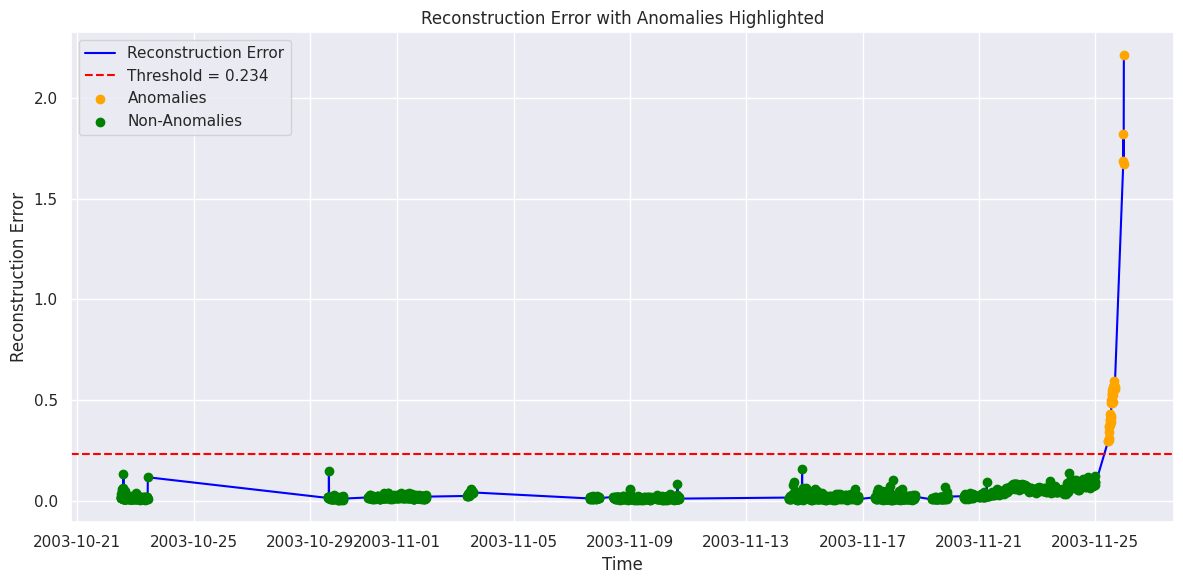

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors.index, reconstruction_errors['Reconstruction Error'], label='Reconstruction Error', color='blue')
plt.axhline(y=threshold_combined, color='red', linestyle='--', label=f'Threshold = {threshold_combined:.3f}')
anomalies_combined = reconstruction_errors[reconstruction_errors['Anomaly'] == True]
plt.scatter(anomalies_combined.index, anomalies_combined['Reconstruction Error'], color='orange', label='Anomalies', zorder=5)
non_anomalies_combined = reconstruction_errors[reconstruction_errors['Anomaly'] == False]
plt.scatter(non_anomalies_combined.index, non_anomalies_combined['Reconstruction Error'], color='green', label='Non-Anomalies', zorder=5)
plt.title('Reconstruction Error with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [102]:
if merged_data.index.duplicated().any():
    merged_data = merged_data[~merged_data.index.duplicated(keep='first')]

if reconstruction_errors.index.duplicated().any():
    reconstruction_errors = reconstruction_errors[~reconstruction_errors.index.duplicated(keep='first')]

reconstruction_errors_aligned = reconstruction_errors.reindex(merged_data.index)
merged_data['Anomaly'] = reconstruction_errors_aligned['Anomaly']

In [103]:
merged_data.to_csv('AnomalyDetection/BearingTest_1_Anomalies.csv')

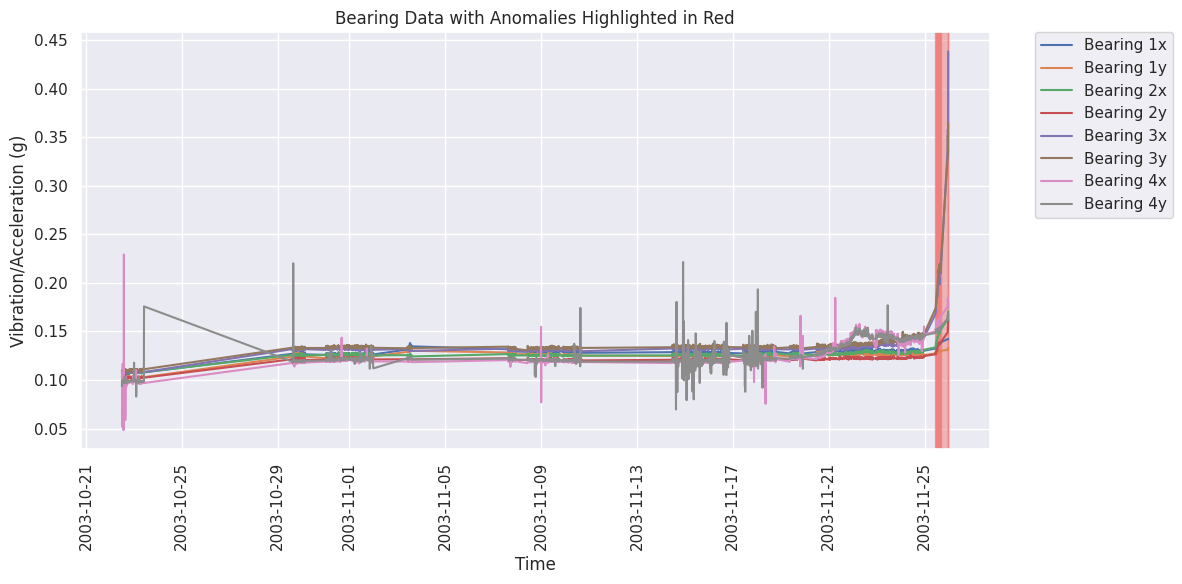

In [104]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Throughout most of the test period (starting from around October 21, 2003, to late November 2003), the vibration/acceleration values for all the bearings remain fairly stable with small fluctuations. This is expected as the bearings were functioning normally for the majority of the test duration.

- Towards the end of the test (around November 25, 2003), the plot shows a significant increase in vibration/acceleration for Bearing 3. This sharp increase indicates the onset of the inner race defect. The description specifies that Bearing 3 experienced an inner race defect, which is supported by the plot, as the anomaly detection highlights this time period and the sharp rise is seen.

- Similarly, Bearing 4 also shows a sharp rise in vibration/acceleration at the same time as Bearing 3. The description mentions a roller element defect in Bearing 4, and this is confirmed by the anomaly highlighted in the plot as well as the corresponding rise in vibration.